In [1]:
import time
import sys, os
import pickle
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from veloproj import *
from veloproj.model import leastsq_pt
from IPython import display
from matplotlib import pyplot as plt
import anndata

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-6', 
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--data-dir', '/data/users/cqiao/notebooks/data/organoids.h5ad',
                               '--model-name', 'baseline_tmp.cpt',
                               '--exp-name', 'baseline_scEU',
                               '--nb_g_src', "SU",
                               '--device', 'cuda:0'
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("3", "1"), ("3", "2")]
k_cluster = "monocle_branch_id"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, model, lr=args.lr, weight_decay=args.weight_decay, save_name="tmp.cpt"):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    lr = args.lr  
    i, losses = 0, [sys.maxsize]  
    min_loss = losses[-1]
    model_saved = False

    model.train()
    while i < args.n_epochs:
        i += 1
        loss = train_step_AE([tensor_s, tensor_u], model, optimizer, xyids=[0, 1], device=device)
        losses.append(loss)
        if i % args.log_interval == 0:
            if losses[-1] < min_loss:
                min_loss = losses[-1]
                torch.save(model.state_dict(), os.path.join(args.output, save_name))
                model_saved = True
            else:
                if model_saved:
                    model.load_state_dict(torch.load(os.path.join(args.output, save_name)))
                    model = model.to(device)
                lr *= args.lr_decay
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr

            print("Train Epoch: {:2d}/{:2d} \tLoss: {:.6f}"
                  .format(i, args.n_epochs, losses[-1]))

    plt.plot(losses[1:])
    if losses[-1] < min_loss:
        torch.save(model.state_dict(), os.path.join(args.output, save_name))
    return model

In [6]:
adata = scanpy.read_h5ad(args.data_dir)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.68 0.32]
Filtered out 3746 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:15) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 3831 × 2000
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'rotated_umap1', 'rotated_umap2', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'conn

computing velocities
    finished (0:00:00) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:05) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_scEU_stochastical.png


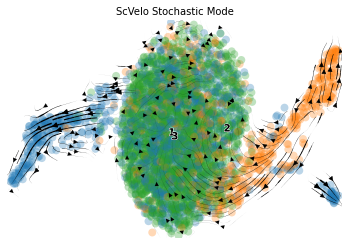

# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.15110905, ('3', '2'): 0.08070849}
Total Mean: 0.11590877175331116
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.79888743, ('3', '2'): 0.8207456}
Total Mean: 0.8098164796829224
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): 0.10778322538849838, ('3', '2'): 0.07385793843483786}
Total Mean: 0.09082058191166811
# In-cluster Coherence
{'1': 0.80496264, '2': 0.85452604, '3': 0.83365995}
Total Mean: 0.8310495018959045
# In-cluster Confidence
{'1': 0.7199736277122568, '2': 0.7906060736097675, '3': 0.780544162448959}
Total Mean: 0.7637079545903278


In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity')
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis='X_umap', color=k_cluster,
                                title='ScVelo Stochastic Mode', save="scEU_stochastical.png")
exp_metrics['stc_mode'] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

In [8]:
spliced = adata.layers['Ms']
unspliced = adata.layers['Mu']
tensor_s, tensor_u = torch.FloatTensor(spliced).to(device), torch.FloatTensor(unspliced).to(device)
tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

Train Epoch: 100/20000 	Loss: 0.971400
Train Epoch: 200/20000 	Loss: 0.957495
Train Epoch: 300/20000 	Loss: 0.946777
Train Epoch: 400/20000 	Loss: 0.938211
Train Epoch: 500/20000 	Loss: 0.932079
Train Epoch: 600/20000 	Loss: 0.927080
Train Epoch: 700/20000 	Loss: 0.923032
Train Epoch: 800/20000 	Loss: 0.919751
Train Epoch: 900/20000 	Loss: 0.916538
Train Epoch: 1000/20000 	Loss: 0.913725
Train Epoch: 1100/20000 	Loss: 0.910855
Train Epoch: 1200/20000 	Loss: 0.908224
Train Epoch: 1300/20000 	Loss: 0.905419
Train Epoch: 1400/20000 	Loss: 0.902456
Train Epoch: 1500/20000 	Loss: 0.899316
Train Epoch: 1600/20000 	Loss: 0.895843
Train Epoch: 1700/20000 	Loss: 0.892035
Train Epoch: 1800/20000 	Loss: 0.887872
Train Epoch: 1900/20000 	Loss: 0.883130
Train Epoch: 2000/20000 	Loss: 0.877850
Train Epoch: 2100/20000 	Loss: 0.872146
Train Epoch: 2200/20000 	Loss: 0.866016
Train Epoch: 2300/20000 	Loss: 0.859381
Train Epoch: 2400/20000 	Loss: 0.852356
Train Epoch: 2500/20000 	Loss: 0.844995
Train Epo

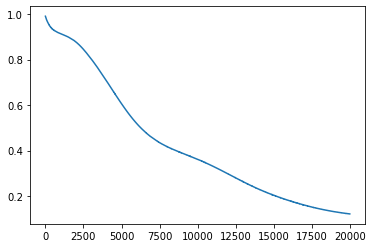

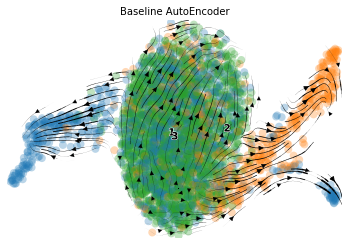

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.123455025, ('3', '2'): 0.10507295}
Total Mean: 0.11426398903131485
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.99995995, ('3', '2'): 0.9999645}
Total Mean: 0.9999622106552124
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): -0.01717999876145484, ('3', '2'): 0.026218094467819097}
Total Mean: 0.004519047853182129
# In-cluster Coherence
{'1': 0.999964, '2': 0.9999737, '3': 0.99996686}
Total Mean: 0.9999682307243347
# In-cluster Confidence
{'1': 0.999952569110504, '2': 0.9999637848790279, '3': 0.9999618771360881}
Total Mean: 0.9999594103752066


In [9]:
def expBaseAE(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    
    model = get_baseline_AE(in_dim, z_dim, h_dim).to(device)
    model = main_AE(args, model, save_name=f"baseAE_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
        
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Baseline AutoEncoder",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expBaseAE(adata, exp_metrics)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Train Epoch: 100/20000 	Loss: 0.914358
Train Epoch: 200/20000 	Loss: 0.913266
Train Epoch: 300/20000 	Loss: 0.912194
Train Epoch: 400/20000 	Loss: 0.911092
Train Epoch: 500/20000 	Loss: 0.909916
Train Epoch: 600/20000 	Loss: 0.908619
Train Epoch: 700/20000 	Loss: 0.907138
Train Epoch: 800/20000 	Loss: 0.905410
Train Epoch: 900/20000 	Loss: 0.903364
Train Epoch: 1000/20000 	Loss: 0.900965
Train Epoch: 1100/20000 	Loss: 0.898235
Train Epoch: 1200/20000 	Loss: 0.895257
Train Epoch: 1300/20000 	Loss: 0.892113
Train Epoch: 1400/20000 	Loss: 0.888855
Train Epoch: 1500/20000 	Loss: 0.885498
Train Epoch: 1600/20000 	Loss: 0.882035
Train Epoch: 1700/20000 	Loss: 0.878454
Train Epoch: 1800/20000 	Loss: 0.874749
Train Epoch: 

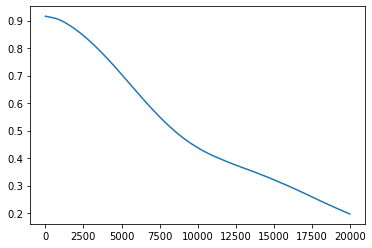

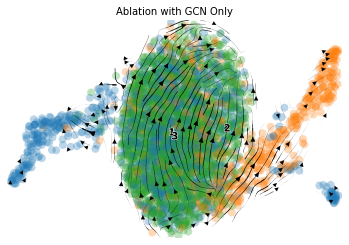

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.13480419, ('3', '2'): 0.0692126}
Total Mean: 0.1020083948969841
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.99999225, ('3', '2'): 0.99999255}
Total Mean: 0.9999923706054688
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): 0.017132547591074982, ('3', '2'): 0.02799766005308504}
Total Mean: 0.02256510382208001
# In-cluster Coherence
{'1': 0.9999939, '2': 0.99999464, '3': 0.9999932}
Total Mean: 0.9999939799308777
# In-cluster Confidence
{'1': 0.9999925989583628, '2': 0.9999933321557659, '3': 0.9999929013833477}
Total Mean: 0.9999929441658254


In [10]:
def expAblationCohAgg(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    g_basis = args.nb_g_src
    model = get_ablation_CohAgg(
                                adata,
                                in_dim,
                                z_dim,
                                h_dim,
                                g_basis,
                                device)
    model = main_AE(args, model, save_name=f"CohAgg_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
        
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Ablation with GCN Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation GCN Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationCohAgg(adata, exp_metrics)

Train Epoch: 100/20000 	Loss: 0.954311
Train Epoch: 200/20000 	Loss: 0.940777
Train Epoch: 300/20000 	Loss: 0.917184
Train Epoch: 400/20000 	Loss: 0.887206
Train Epoch: 500/20000 	Loss: 0.853462
Train Epoch: 600/20000 	Loss: 0.823672
Train Epoch: 700/20000 	Loss: 0.798750
Train Epoch: 800/20000 	Loss: 0.779408
Train Epoch: 900/20000 	Loss: 0.763703
Train Epoch: 1000/20000 	Loss: 0.748589
Train Epoch: 1100/20000 	Loss: 0.738436
Train Epoch: 1200/20000 	Loss: 0.726837
Train Epoch: 1300/20000 	Loss: 0.714718
Train Epoch: 1400/20000 	Loss: 0.708036
Train Epoch: 1500/20000 	Loss: 0.696464
Train Epoch: 1600/20000 	Loss: 0.681879
Train Epoch: 1700/20000 	Loss: 0.676468
Train Epoch: 1800/20000 	Loss: 0.667491
Train Epoch: 1900/20000 	Loss: 0.658575
Train Epoch: 2000/20000 	Loss: 0.652828
Train Epoch: 2100/20000 	Loss: 0.646435
Train Epoch: 2200/20000 	Loss: 0.640065
Train Epoch: 2300/20000 	Loss: 0.638427
Train Epoch: 2400/20000 	Loss: 0.634432
Train Epoch: 2500/20000 	Loss: 0.627307
Train Epo

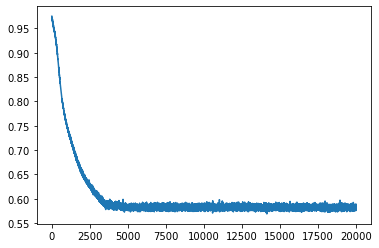

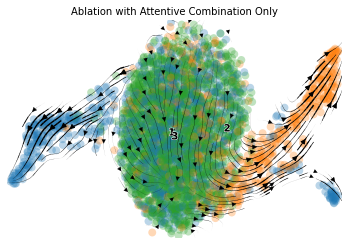

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.17380941, ('3', '2'): 0.18039502}
Total Mean: 0.1771022081375122
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.99824715, ('3', '2'): 0.9983712}
Total Mean: 0.9983091354370117
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): 0.1525504422406833, ('3', '2'): 0.1716134115096357}
Total Mean: 0.1620819268751595
# In-cluster Coherence
{'1': 0.9984132, '2': 0.99842036, '3': 0.99850845}
Total Mean: 0.9984473586082458
# In-cluster Confidence
{'1': 0.9980911053470428, '2': 0.9980930846433655, '3': 0.9984026940307807}
Total Mean: 0.9981956280070631


In [11]:
def expAblationAttComb(adata, exp_metrics):
    from sklearn.decomposition import PCA
    n_cells, n_genes = adata.X.shape
    z_dim = args.z_dim
    g_rep_dim = args.g_rep_dim
    h_dim = args.h_dim
    k_dim = args.k_dim
    gb_tau = args.gumbsoft_tau
    G_embeddings = PCA(n_components=g_rep_dim).fit_transform(adata.X.T.toarray())
    
    model = get_ablation_attcomb(
        z_dim,
        n_genes,
        n_cells,
        h_dim,
        k_dim,
        G_embeddings,
        g_rep_dim,
        gb_tau,
        device)
    
            
    model = main_AE(args, model, save_name=f"AttComb_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Ablation with Attentive Combination Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation AttComb Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationAttComb(adata, exp_metrics)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


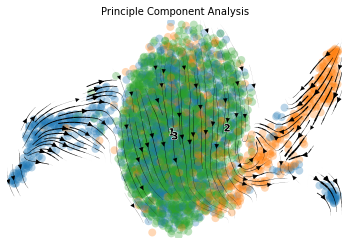

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.0877989, ('3', '2'): 0.10251595}
Total Mean: 0.0951574295759201
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.976974, ('3', '2'): 0.97853374}
Total Mean: 0.9777538776397705
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): 0.0335768545024567, ('3', '2'): 0.015345423596363534}
Total Mean: 0.024461139049410115
# In-cluster Coherence
{'1': 0.96934927, '2': 0.91276455, '3': 0.9810585}
Total Mean: 0.9543907642364502
# In-cluster Confidence
{'1': 0.9631729140532332, '2': 0.9021730575266903, '3': 0.9802124644689892}
Total Mean: 0.948519478682971


In [12]:
def expPCA(adata, exp_metrics):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(pca, 
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy()
                                  )
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Principle Component Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline PCA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expPCA(adata, exp_metrics)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


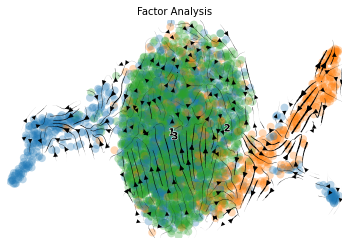

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('3', '1'): 0.1405113, ('3', '2'): 0.14074613}
Total Mean: 0.14062872529029846
# Cross-Boundary Velocity Coherence (A->B)
{('3', '1'): 0.5521607780197547, ('3', '2'): 0.541728156417746}
Total Mean: 0.5469444672187503
# Cross-Boundary Direction Correctness (A->B)
{('3', '1'): -0.005941441984938962, ('3', '2'): -0.08011213285827426}
Total Mean: -0.04302678742160661
# In-cluster Coherence
{'1': 0.6033790539922725, '2': 0.570696128291131, '3': 0.5500352534874317}
Total Mean: 0.5747034785902785
# In-cluster Confidence
{'1': 0.5254697199422714, '2': 0.5103576868349354, '3': 0.5485948969846645}
Total Mean: 0.5281407679206237


In [13]:
def expFA(adata, exp_metrics):
    from sklearn.decomposition import FactorAnalysis
    method = FactorAnalysis(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(method,
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy()
                                  )
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Factor Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline FA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expFA(adata, exp_metrics)

In [14]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)